In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [2]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)


In [3]:
import torch
from torch_geometric.data import HeteroData

# Initialize graph
data = HeteroData()

# Node ID mappings
campaign_mapping = {}  # {campaign_id: index}
platform_mapping = {}  # {platform_id: index}
channel_mapping = {}  # {channel_id: index}
advertiser_mapping = {}  # {advertiser_word: index}
keywords_mapping = {}  # {keyword: index}
search_tags_mapping = {}  # {search_tag: index}



# Unique ID counters
campaign_counter = 0
platform_counter = 0
channel_counter = 0
advertiser_counter = 0
keywords_counter = 0
search_tags_counter = 0


## Campaign Nodes
### Each campaign treated as single entity across different rows

In [4]:
campaign_features = []  # Store campaign features

# Assuming 'campaign_data' is a DataFrame containing 'campaign_index' and 'no_of_days'
campaign_data = df[['campaign_index', 'no_of_days']]

# Iterate over rows of the DataFrame using iterrows
for _, row in campaign_data.iterrows():
    campaign_id = row['campaign_index']  # Extract campaign_id
    features = row['no_of_days']  # Extract features (no_of_days)
    
    if campaign_id not in campaign_mapping:
        campaign_mapping[campaign_id] = campaign_counter
        campaign_features.append([features])  # Store features (make sure it's a list)
        campaign_counter += 1

# Convert to tensor
data['campaign'].x = torch.tensor(campaign_features, dtype=torch.float)



## Platform Node

In [5]:
platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features

# Assign unique indices
platform_mapping = {'DV360': 0, 'Google Ads': 1, 'Facebook Ads': 2}


## Channel  Node

In [6]:
channel_data = df[['Display','Mobile','Search','Social','Video']].values
# Convert to tensor format
channel_features = torch.tensor(channel_data, dtype=torch.float)
data['channel'].x = channel_features

# Assign unique indices
channel_mapping = {'Display': 4,'Mobile': 0, 'Search': 1, 'Social': 2, 'Video': 3}


## Advertiser Node

In [7]:
advertiser_features = []  # Store advertiser embeddings
advertiser_mapping = {}  # Assign indices

# Fetching both the 'advertiser_name' and the embedding columns
advertiser_data = df[['advertiser_name'] + [f'advertiser_emb_{i}' for i in range(50)]]

# Iterate over rows of the DataFrame using iterrows
for _, row in advertiser_data.iterrows():
    advertiser_word = row['advertiser_name'].iloc[0]  # Ensure you get a scalar value
    embedding = row[[f'advertiser_emb_{i}' for i in range(50)]].values  # Extract the 50D embedding

    
    if advertiser_word not in advertiser_mapping:
        advertiser_mapping[advertiser_word] = advertiser_counter
        advertiser_features.append(embedding)  # Store the embedding as a list
        advertiser_counter += 1

# Convert to tensor
data['advertiser'].x = torch.tensor(advertiser_features, dtype=torch.float)



C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_17728\340588808.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data['advertiser'].x = torch.tensor(advertiser_features, dtype=torch.float)


## Keywords Node

In [8]:
keyword_features = []  # Store keyword embeddings
keywords_mapping = {}  # Assign indices

# Fetching both the 'keyword' and the embedding columns
keyword_data = df[['keyword'] + [f'keyword_emb_{i}' for i in range(50)]]

# Iterate over rows of the DataFrame using iterrows
for _, row in keyword_data.iterrows():
    keyword = row['keyword']  # Extract keyword
    embedding = row[[f'keyword_emb_{i}' for i in range(50)]].values  # Extract the 50D embedding
    
    if keyword not in keywords_mapping:
        keywords_mapping[keyword] = keywords_counter
        keyword_features.append(embedding)  # Store the embedding as a list
        keywords_counter += 1

# Convert to tensor
data['keyword'].x = torch.tensor(keyword_features, dtype=torch.float)

## Creative Node

In [9]:
creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)

# Assign to creative nodes
data['creative'].x = creative_features  # Assign binary feature


## search tag Node

In [10]:
search_tag_features = []  # Store search_tag embeddings
search_tags_mapping = {}  # Assign indices

# Fetching both the 'search_tag' and the embedding columns
search_tag_data = df[['search_tag'] + [f'search_tag_emb_{i}' for i in range(50)]]

# Iterate over rows of the DataFrame using iterrows
for _, row in search_tag_data.iterrows():
    search_tag = row['search_tag']  # Extract search_tag
    embedding = row[[f'search_tag_emb_{i}' for i in range(50)]].values  # Extract the 50D embedding
    
    if search_tag not in search_tags_mapping:
        search_tags_mapping[search_tag] = search_tags_counter
        search_tag_features.append(embedding)  # Store the embedding as a list
        search_tags_counter += 1

# Convert to tensor
data['search_tag'].x = torch.tensor(search_tag_features, dtype=torch.float)

### ➤ Campaign → Platform Edges

In [11]:
campaign_platform_edges = []
campaign_platform_data = []


# Iterate over your dataset (df_filtered) and get campaign_id and platform
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    platform_name = row['platform']   # Get platform name
    campaign_platform_data.append([campaign_id, platform_name])  # Add to list

for campaign_id, platform_name in campaign_platform_data:  # (campaign_id, platform_name)
    campaign_idx = campaign_mapping[campaign_id]
    platform_idx = platform_mapping[platform_name]

    campaign_platform_edges.append([campaign_idx, platform_idx])

data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor(campaign_platform_edges, dtype=torch.long).T


### ➤ Campaign → Channel Edges

In [12]:
campaign_channel_edges = []
campaign_channel_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and channel
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    channel_name = row['channel_name']   # Get channel name
    campaign_channel_data.append([campaign_id, channel_name])  # Add to list

for campaign_id, channel_name in campaign_channel_data:  # (campaign_id, channel_name)
    campaign_idx = campaign_mapping[campaign_id]
    channel_idx = channel_mapping[channel_name]

    campaign_channel_edges.append([campaign_idx, channel_idx])

data['campaign', 'uses', 'channel'].edge_index = torch.tensor(campaign_channel_edges, dtype=torch.long).T


### ➤ Campaign → Advertiser Edges

In [13]:
campaign_advertiser_edges = []
campaign_advertiser_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and advertiser_name
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    advertiser_name = row['advertiser_name'].values[0]    # Get advertiser name
    campaign_advertiser_data.append([campaign_id, advertiser_name])  # Add to list

for campaign_id, advertiser_name in campaign_advertiser_data:  # (campaign_id, advertiser_name)
    campaign_idx = campaign_mapping[campaign_id]
    advertiser_idx = advertiser_mapping[advertiser_name]
    campaign_advertiser_edges.append([campaign_idx, advertiser_idx])

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.tensor(campaign_advertiser_edges, dtype=torch.long).T


### ➤ Campaign → keywords Edges

In [14]:
campaign_keywords_edges = []
campaign_keywords_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and keywords
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    keywords = row['keywords']   # Get keywords name
    campaign_keywords_data.append([campaign_id, keywords])  # Add to list

for campaign_id, keywords in campaign_keywords_data:  # (campaign_id, keywords)
    campaign_idx = campaign_mapping[campaign_id]
    keywords_idx = keywords_mapping[keywords]
    campaign_keywords_edges.append([campaign_idx, keywords_idx])

data['campaign', 'belongs_to', 'keyword'].edge_index = torch.tensor(campaign_keywords_edges, dtype=torch.long).T


### ➤ Campaign → Creative Edges

In [15]:
campaign_creates_edges = []
campaign_creates_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and creative
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    creative = row['has_image']   # Get creative
    campaign_creates_data.append([campaign_id, creative])  # Add to list

for campaign_id, creative in campaign_creates_data:  # (campaign_id, creative)
    campaign_idx = campaign_mapping[campaign_id]

    campaign_creates_edges.append([campaign_idx, creative])

data['campaign', 'uses', 'creative'].edge_index = torch.tensor(campaign_creates_edges, dtype=torch.long).T

### ➤ Platform → Channel Edges

In [16]:
platform_channel_data = {
    'DV360': ['Display', 'Mobile', 'Search', 'Social', 'Video'],
    'Google Ads': ['Display', 'Mobile', 'Search', 'Social', 'Video'],
    'Facebook Ads': ['Display', 'Mobile', 'Search', 'Social', 'Video']
}

# List to store platform-channel edges
platform_channel_edges = []

# Iterate over the platform-channel relationships
for platform, channels in platform_channel_data.items():
    # Get the platform index
    platform_idx = platform_mapping[platform]
    
    # Iterate over the channels associated with this platform
    for channel in channels:
        # Get the channel index
        channel_idx = channel_mapping[channel]
        
        # Add the edge (platform -> channel)
        platform_channel_edges.append([platform_idx, channel_idx])

# Convert to tensor and assign to the graph
data['platform', 'supports', 'channel'].edge_index = torch.tensor(platform_channel_edges, dtype=torch.long).T


### ➤ Campaign → Search tag Edges

In [17]:
campaign_searchtag_edges = []
campaign_searchtag_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and keywords
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    search_tag = row['search_tags']   # Get keywords name
    campaign_searchtag_data.append([campaign_id, search_tag])  # Add to list

for campaign_id, keywords in campaign_searchtag_data:  # (campaign_id, keywords)
    campaign_idx = campaign_mapping[campaign_id]
    search_tag_idx = search_tags_mapping[search_tag]
    campaign_searchtag_edges.append([campaign_idx, search_tag_idx])

data['campaign', 'belongs_to', 'search_tags'].edge_index = torch.tensor(campaign_searchtag_edges, dtype=torch.long).T


### ➤ Platform → Keywords Edges

In [18]:
import json

# Load the data from the JSON file
with open('../Datasets/platform_keyword_data.json', 'r') as f:
    platform_keyword_data = json.load(f)

print(platform_keyword_data)  # You can now use this data in your program


{'Facebook Ads': ['huggie earrings', 'clip-on earrings', 'nature-inspired jewelry', 'dazzling jewelry', 'dangle earrings', 'boho jewelry', 'fashionable jewelry', 'elegant and modern jewelry', 'edwardian jewelry', 'vintage-inspired jewelry', 'costume jewelry', 'sophisticated jewelry', 'renaissance jewelry', 'summer jewelry', 'tassel earrings', 'initial jewelry', 'threader earrings', 'unique jewelry', 'cuff bracelets', 'brooches', 'personalized jewelry', 'beach jewelry', 'baroque jewelry', 'beaded bracelets', 'handmade jewelry', 'modern jewelry', 'art deco jewelry', 'statement rings', 'concert jewelry', 'stackable bracelets', 'drop earrings', 'stud earrings', 'retro jewelry', 'vibrant jewelry', 'victorian jewelry', 'casual jewelry', 'chic jewelry', 'everyday jewelry', 'affordable statement jewelry', 'zodiac jewelry', 'arm cuffs', 'fall jewelry', 'statement necklaces', 'body chains', 'gemstone jewelry', 'glamorous jewelry', 'exquisite jewelry', 'party jewelry', 'charm bracelets', 'bohemia

In [19]:
platform_keyword_edges = []

# Iterate over the platform-to-keyword relationships
for platform, keywords in platform_keyword_data.items():
    # Get the platform index
    platform_idx = platform_mapping[platform]

    # Iterate over the associated keywords
    for keyword in keywords:
        # Get the keyword index
        keyword_idx = keywords_mapping[keyword]

        # Add the edge (platform -> keyword)
        platform_keyword_edges.append([platform_idx, keyword_idx])

# Convert to tensor and assign to the graph
data['platform', 'supports', 'keyword'].edge_index = torch.tensor(platform_keyword_edges, dtype=torch.long).T


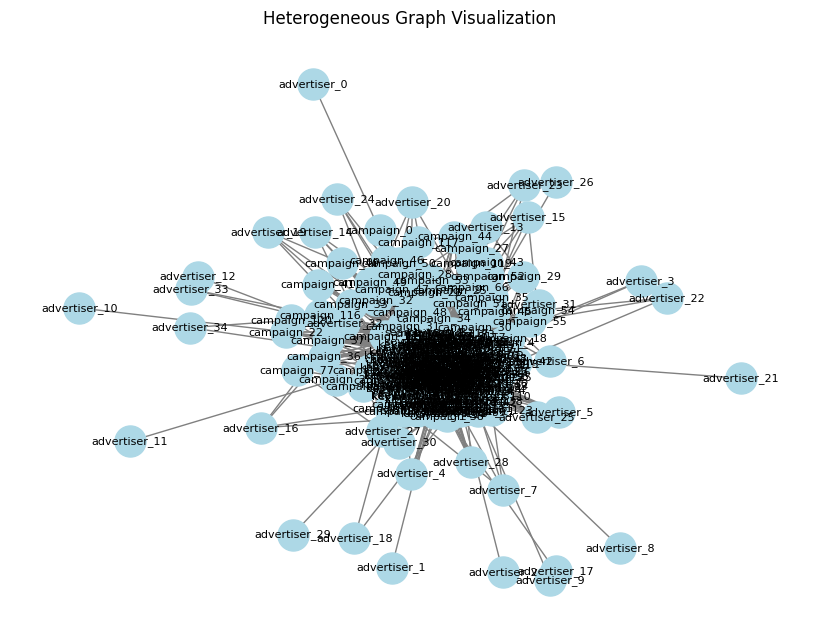

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert heterogeneous PyG graph to NetworkX for each edge type
G = nx.Graph()

# Loop through different edge types
for edge_type in data.edge_types:
    src_type, rel, dst_type = edge_type  # Extract node and relation names
    edge_index = data[edge_type].edge_index.numpy().T  # Get edges as NumPy array
    
    # Add edges to NetworkX graph
    for src, dst in edge_index:
        G.add_edge(f"{src_type}_{src}", f"{dst_type}_{dst}", relation=rel)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)

plt.title("Heterogeneous Graph Visualization")
plt.show()


In [21]:
print(df['engagement_level'].isna().sum())


1


In [22]:
# Count unique engagement categories per campaign
df_check = df.groupby('campaign_index')['engagement_level'].nunique()

# Find campaigns with more than one unique engagement category
conflicting_campaigns = df_check[df_check > 1]

# Display the number of such campaigns
print(f"Number of campaigns with multiple engagement categories: {len(conflicting_campaigns)}")

# Show detailed conflicts (optional)
if not conflicting_campaigns.empty:
    print("\nProblematic campaigns and their unique engagement levels:\n")
    for campaign_id in conflicting_campaigns.index:
        unique_levels = df[df['campaign_index'] == campaign_id]['engagement_level'].unique()
        print(f"Campaign {campaign_id} has engagement levels: {list(unique_levels)}")

Number of campaigns with multiple engagement categories: 111

Problematic campaigns and their unique engagement levels:

Campaign 1 has engagement levels: [2.0, 3.0, 1.0, 0.0]
Campaign 2 has engagement levels: [2.0, 1.0, 3.0, 0.0]
Campaign 3 has engagement levels: [1.0, 2.0, 3.0, 0.0]
Campaign 4 has engagement levels: [1.0, 2.0, 0.0, 3.0]
Campaign 5 has engagement levels: [2.0, 3.0]
Campaign 6 has engagement levels: [2.0, 0.0, 1.0, 3.0]
Campaign 8 has engagement levels: [1.0, 2.0]
Campaign 9 has engagement levels: [3.0, 1.0, 0.0, 2.0]
Campaign 10 has engagement levels: [2.0, 0.0, 1.0, 3.0]
Campaign 11 has engagement levels: [0.0, 3.0, 2.0, 1.0]
Campaign 12 has engagement levels: [3.0, 2.0, 1.0, 0.0]
Campaign 13 has engagement levels: [2.0, 1.0, 3.0, 0.0]
Campaign 14 has engagement levels: [2.0, 3.0, 1.0, 0.0]
Campaign 15 has engagement levels: [0.0, 2.0, 1.0, 3.0]
Campaign 16 has engagement levels: [2.0, 1.0, 0.0, 3.0]
Campaign 17 has engagement levels: [1.0, 2.0, 3.0, 0.0]
Campaign 18

In [23]:
# Assign the most frequent engagement level per campaign
df_campaign_labels = df.groupby('campaign_index')['engagement_level'].agg(lambda x: x.mode()[0])

# Convert to tensor
engagement_labels = torch.tensor(df_campaign_labels.values, dtype=torch.long)

# Assign to campaigns
data['campaign'].y = engagement_labels


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class EngagementGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EngagementGNN, self).__init__()
        
        # First GAT layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        
        # Second GAT layer
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        
        # Final output layer
        self.out = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Activation function
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.out(x)
        return x


Epoch 1/100, Loss: 1.4079, Accuracy: 0.0645
Epoch 2/100, Loss: 1.4072, Accuracy: 0.1452
Epoch 3/100, Loss: 1.4065, Accuracy: 0.1452
Epoch 4/100, Loss: 1.4057, Accuracy: 0.1452
Epoch 5/100, Loss: 1.4050, Accuracy: 0.1935
Epoch 6/100, Loss: 1.4043, Accuracy: 0.1935
Epoch 7/100, Loss: 1.4036, Accuracy: 0.1935
Epoch 8/100, Loss: 1.4028, Accuracy: 0.2097
Epoch 9/100, Loss: 1.4021, Accuracy: 0.2097
Epoch 10/100, Loss: 1.4014, Accuracy: 0.2097
Epoch 11/100, Loss: 1.4006, Accuracy: 0.2177
Epoch 12/100, Loss: 1.3999, Accuracy: 0.2097
Epoch 13/100, Loss: 1.3992, Accuracy: 0.2097
Epoch 14/100, Loss: 1.3984, Accuracy: 0.2097
Epoch 15/100, Loss: 1.3977, Accuracy: 0.2097
Epoch 16/100, Loss: 1.3970, Accuracy: 0.2258
Epoch 17/100, Loss: 1.3962, Accuracy: 0.2177
Epoch 18/100, Loss: 1.3955, Accuracy: 0.2097
Epoch 19/100, Loss: 1.3947, Accuracy: 0.2097
Epoch 20/100, Loss: 1.3939, Accuracy: 0.2177
Epoch 21/100, Loss: 1.3932, Accuracy: 0.2177
Epoch 22/100, Loss: 1.3924, Accuracy: 0.2177
Epoch 23/100, Loss:

c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1100
           1       0.25      0.37      0.30      2900
           2       0.61      0.57      0.59      7600
           3       0.08      0.10      0.09       800

    accuracy                           0.44     12400
   macro avg       0.23      0.26      0.24     12400
weighted avg       0.44      0.44      0.44     12400



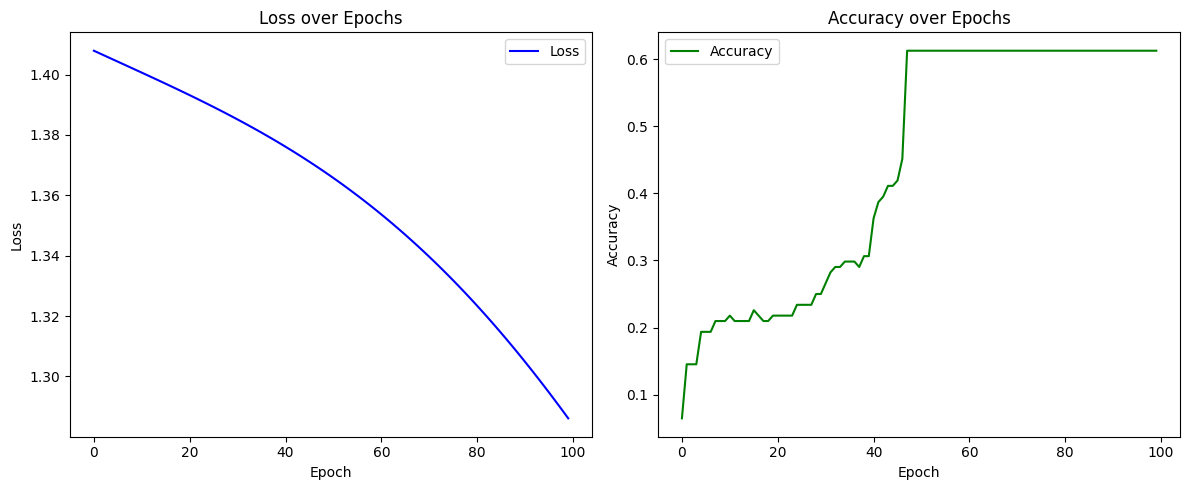

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch

def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, dim=1)  # Get the predicted class
    correct = (predicted == labels).sum()  # Count the number of correct predictions
    accuracy = correct / len(labels)  # Accuracy as a fraction
    return accuracy.item()  # Return as a scalar value

# Define training function
def train(model, data, optimizer, criterion, epochs=100):
    all_predictions = []  # List to store all predictions
    all_labels = []  # List to store all true labels
    loss_values = []  # List to store loss values
    accuracy_values = []  # List to store accuracy values
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        
        optimizer.zero_grad()  # Clear the gradients
        
        # Use node features for campaigns (or other node types as needed)
        campaign_features = data['campaign'].x  # Assuming 'campaign' nodes have features
        edge_index = data['campaign', 'belongs_to', 'advertiser'].edge_index  # Get edge index for the graph
        
        # Forward pass through the model with both node features and edge index
        out = model(campaign_features, edge_index)  # Pass both node features and edge index
        
        # Compute loss (assume labels are in 'campaign' node type)
        loss = criterion(out, data['campaign'].y)  # Assuming target labels are in data['campaign'].y

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights
        
        # Compute accuracy
        accuracy = compute_accuracy(out, data['campaign'].y)  # Assuming target is for 'campaign' nodes
        
        # Get predictions and labels
        predictions = torch.argmax(out, dim=1).cpu().numpy()
        labels = data['campaign'].y.cpu().numpy()
        
        # Accumulate the predictions and labels for the final report
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        
        # Store loss and accuracy for plotting
        loss_values.append(loss.item())
        accuracy_values.append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # After training ends, generate the final classification report
    print("\nFinal Classification Report:")
    report = classification_report(all_labels, all_predictions)
    print(report)

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_values, label='Loss', color='blue')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_values, label='Accuracy', color='green')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Define model
model = EngagementGNN(in_channels=data['campaign'].x.shape[1], 
                      hidden_channels=64, 
                      out_channels=4)  # 5 engagement levels

# Optimizer & Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
train(model, data, optimizer, criterion, epochs=100)


In [26]:
import torch
import numpy as np

def process_user_input(user_input):
    """
    Convert user inputs into numerical tensors for prediction.
    
    Args:
    user_input (dict): Dictionary containing user-provided values.

    Returns:
    dict: A dictionary with tensors formatted for model input.
    """

    # Extract features from user input
    campaign_features = [user_input['no_of_days']]  # Numeric value

    # One-hot encode platform (DV360, Facebook Ads, Google Ads)
    platform_vector = [0, 0, 0]
    if user_input['platform'] in platform_mapping:
        platform_vector[platform_mapping[user_input['platform']]] = 1
    
    # One-hot encode channel (Display, Mobile, Search, Social, Video)
    channel_vector = [0, 0, 0, 0, 0]
    if user_input['channel'] in channel_mapping:
        channel_vector[channel_mapping[user_input['channel']]] = 1
    
    # Advertiser embedding (use existing if available, otherwise random)
    if user_input['advertiser_name'] in advertiser_mapping:
        advertiser_vector = advertiser_mapping[user_input['advertiser_name']]
    else:
        advertiser_vector = np.random.rand(50)  # Random 50D embedding
    
    # Keyword embedding (use existing if available, otherwise random)
    if user_input['keyword'] in keywords_mapping:
        keyword_vector = keywords_mapping[user_input['keyword']]
    else:
        keyword_vector = np.random.rand(50)  # Random 50D embedding

    # Creative feature (binary)
    creative_vector = [user_input['has_image']]  # 0 or 1

    # Search tag embedding (use existing if available, otherwise random)
    if user_input['search_tag'] in search_tags_mapping:
        search_tag_vector = search_tags_mapping[user_input['search_tag']]
    else:
        search_tag_vector = np.random.rand(50)  # Random 50D embedding

    # Convert all inputs to tensors
    input_tensors = {
        'campaign': torch.tensor([campaign_features], dtype=torch.float),
        'platform': torch.tensor([platform_vector], dtype=torch.float),
        'channel': torch.tensor([channel_vector], dtype=torch.float),
        'advertiser': torch.tensor([advertiser_vector], dtype=torch.float),
        'keyword': torch.tensor([keyword_vector], dtype=torch.float),
        'creative': torch.tensor([creative_vector], dtype=torch.float),
        'search_tag': torch.tensor([search_tag_vector], dtype=torch.float)
    }

    return input_tensors


In [27]:
# Example user input (from an API or user form)
user_input = {
    "no_of_days": 10,  # Numeric input
    "platform": "Google Ads",  # One-hot encoded
    "channel": "Social",  # One-hot encoded
    "advertiser_name": "Nike",  # Mapped to embedding
    "keyword": "Sports",  # Mapped to embedding
    "has_image": 1,  # Binary feature
    "search_tag": "Athletic"  # Mapped to embedding
}

# Convert input to numeric tensors
formatted_inputs = process_user_input(user_input)

# Display formatted tensors
for key, value in formatted_inputs.items():
    print(f"{key}: {value.shape}")


campaign: torch.Size([1, 1])
platform: torch.Size([1, 3])
channel: torch.Size([1, 5])
advertiser: torch.Size([1, 50])
keyword: torch.Size([1, 50])
creative: torch.Size([1, 1])
search_tag: torch.Size([1, 50])


In [28]:
new_advertiser = "New Advertiser Name"

if new_advertiser not in advertiser_mapping:
    advertiser_mapping[new_advertiser] = len(advertiser_mapping)
advertiser_idx = advertiser_mapping[new_advertiser]


In [29]:
def predict_engagement(model, input_data):
    """
    Predict engagement level using the trained model.
    
    Args:
    model (torch.nn.Module): Trained GNN model.
    input_data (dict): Dictionary containing tensors of user input features.

    Returns:
    torch.Tensor: Predicted engagement level.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients
        prediction = model(input_data)

    return prediction


In [30]:
# Assuming 'gnn_model' is your trained GNN model
prediction = predict_engagement(model, formatted_inputs)

print("Predicted Engagement Level:", prediction.item())


TypeError: EngagementGNN.forward() missing 1 required positional argument: 'edge_index'